<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_BRAZPD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - BRAZPD Dataset
This notebook is based on the [Batch-DLG Evolution - Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the IRIS Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked. We now modify the code to run on the BRAZPD dataset.

# Setting up Libaries and Utilities

In [ ]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [ ]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
!cp 'drive/MyDrive/UROP/Project Files/BRAZPD_UnofM_all.csv' 'BRAZPD_UnofM_all.csv'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess BRAZPD Dataset

In [ ]:
# convert categorical variables to onehot

In [ ]:
# import BRAZPD dataset
import pandas as pd
import numpy as np
import os

filename = 'BRAZPD_UnofM_all.csv'
df = pd.read_csv(filename, engine='python', encoding = "ISO-8859-1")
print(df.shape)
df['followup1yfull'] = df['Followup'].apply(lambda x: 1 if x >= 12 else 0)

(5707, 1735)


In [ ]:
# grab baseline features and target
baseline_set = ['CenterSizenpatients', 'Age', 'IncidentinPD', 'PrevalentinPDNet', \
                'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'Cancer', 'Stroke','Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'predialysiscare',\
                'timeofpredialysiscare', 'Educationdic4y', 'Region',\
                'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
baseline_set_numerical = ['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore',\
                          'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear',\
                          'BMI', 'Distancefromcenter']
baseline_set_categorical = ['IncidentinPD', 'PrevalentinPDNet', 'PreviousHD', 'Previoustx', \
                            'Peripheralarterydisease', 'Cancer', 'Stroke', 'Hypertension', \
                            'HIV', 'HCV', 'HBC', 'Gender', 'Race', 'predialysiscare', \
                            'Educationdic4y', 'Region']
# NOTE: BMI, Familyincome, and Distancefromcenter are in the numerical set but
# they are given as categories (not known whether ordered); possibly other variables too

In [ ]:
# def data_to_onehot(baseline_set):
#     res = torch.zeros(df[baseline_set].shape[0], 0)
#     for name in baseline_set:
#         maxval = max(df[name])
#         print(df[name].to_numpy())
#         cnt = maxval+1
#         onehot_data = torch.zeros(res.shape[0], cnt)
#         #onehot_data.scatter_(df[name]).scatter_(1, df[], 1)
#
# data_to_onehot(baseline_set)

# def encode_and_bind(original_dataframe, feature_to_encode):
#     #dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     print(pd.get_dummies(df[baseline_set]))
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     return(res)

# encode_and_bind(df, baseline_set[2])

print(pd.concat([pd.get_dummies(df[name]) for name in baseline_set], axis=1))

      1  1  0  1  0  1  0  1  0  1  ...  5  0  1  0  1  1  2  3  4  5
0     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
1     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
2     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
3     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
4     1  1  0  1  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
...  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
5702  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5703  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5704  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5705  1  1  0  1  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5706  1  1  1  0  1  0  1  0  1  0  ...  0  1  0  1  0  0  1  0  0  0

[5707 rows x 36 columns]


In [ ]:
# *** load categorical ***
baseline_set = baseline_set_categorical

targets = ['followup1yfull'] # ["death_event_1y"]

X_baseline = pd.concat([pd.get_dummies(df[name]) for name in baseline_set], axis=1).copy(); X_baseline.fillna(0, inplace=True); X_baseline = X_baseline.to_numpy()
Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

print(X_baseline)
print(Y_baseline)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
# *** load numerical ***
def load_numerical(inp_cnt = 9):
    #baseline_set = ['CenterSizenpatients', 'Age']
    baseline_set = baseline_set_numerical[0:inp_cnt]
    print(baseline_set)

    targets = ['followup1yfull'] # ["death_event_1y"]

    X_baseline = df[baseline_set].copy(); X_baseline.fillna(X_baseline.mean(), inplace=True); X_baseline = X_baseline.to_numpy()
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

X_baseline, Y_baseline = load_numerical(5)

['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome']
[[128.   71.2  81.    0.    3. ]
 [128.   23.3   0.    0.    1. ]
 [128.   49.2  81.    1.    2. ]
 ...
 [ 66.   84.   50.    0.    2. ]
 [ 66.   54.2  50.    0.    1. ]
 [ 66.   77.8  81.    0.    1. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
# rescale BRAZPD dataset
def rescale_data(X_baseline, Y_baseline):
    dst_length = X_baseline.shape[0]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_baseline)
    print(scaled_data)

    torch.manual_seed(100)  # fix a given set of patients
    train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), dst_length - int(dst_length*4/5)])
    train_indices = train_indices.indices
    test_indices = test_indices.indices
    train_data = scaled_data[train_indices]; train_target = Y_baseline[train_indices]
    test_data = scaled_data[test_indices]; test_target = Y_baseline[test_indices]

    input_dim = X_baseline.shape[1]
    output_dim = 2
    print('dimensions: ', input_dim, output_dim)

    return train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)

[[-0.35269546  0.73954953  0.68738219 -1.03516117  1.12721738]
 [-0.35269546 -2.26347891 -1.44938318 -1.03516117 -0.98856278]
 [-0.35269546 -0.63971197  0.68738219  0.09831251  0.0693273 ]
 ...
 [-0.91496972  1.54202894 -0.13039221 -1.03516117  0.0693273 ]
 [-0.91496972 -0.32624345 -0.13039221 -1.03516117 -0.98856278]
 [-0.91496972  1.15332797  0.68738219 -1.03516117 -0.98856278]]
dimensions:  5 2


# Setting up Fully Connected Neural Network

In [ ]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [ ]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet(input_dim, output_dim).to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [ ]:
# setup new FCnet on a subset of the baseline numerical features
def setup_net(inp_cnt = 9):
    X_baseline, Y_baseline = load_numerical(inp_cnt)
    train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)
    net = FcNet(input_dim, output_dim).to(device)
    net.apply(weights_init)
    return net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(3)

['CenterSizenpatients', 'Age', 'Primaryrenaldisease']
[[128.   71.2  81. ]
 [128.   23.3   0. ]
 [128.   49.2  81. ]
 ...
 [ 66.   84.   50. ]
 [ 66.   54.2  50. ]
 [ 66.   77.8  81. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546  0.73954953  0.68738219]
 [-0.35269546 -2.26347891 -1.44938318]
 [-0.35269546 -0.63971197  0.68738219]
 ...
 [-0.91496972  1.54202894 -0.13039221]
 [-0.91496972 -0.32624345 -0.13039221]
 [-0.91496972  1.15332797  0.68738219]]
dimensions:  3 2


# Train Model Normally

score: 679/1142


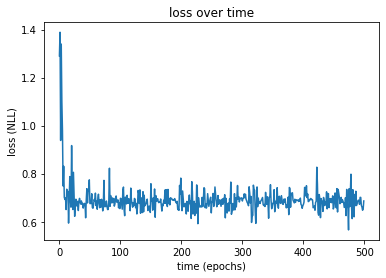

In [ ]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 500
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG (not updated)

In [ ]:
#@title get batch gradient (not updated)
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

In [ ]:
#@title run batch_DLG on one batch (not updated)
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
errors = []
nvars = 9
epochs = 5
batch_size = 1
dlg_rate = 1
verbose = True
for i in range(nvars):
    nvars = i+1
    net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(nvars)
    losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
        = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=200, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = True)
    
    errors.append(torch.flatten(torch.tensor(AA_REs)).numpy())
    print(f'using {nvars} variables: ', AA_REs)
#test_net(net, test_data, test_target)

['CenterSizenpatients']
[[128]
 [128]
 [128]
 ...
 [ 66]
 [ 66]
 [ 66]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546]
 [-0.35269546]
 [-0.35269546]
 ...
 [-0.91496972]
 [-0.91496972]
 [-0.91496972]]
dimensions:  1 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([60.], dtype=torch.float64) tensor([59.9872]) RE (AE / TN):  0.00021273295084635416
closest match: assignment and relative error (%):
tensor([59.9872], dtype=torch.float64) tensor([60.], dtype=torch.float64) 0.02127264084622974


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([74.], dtype=torch.float64) tensor([74.0243]) RE (AE / TN):  0.0003277546650654561
closest match: assignment and relative error (%):
tensor([74.0243], dtype=torch.float64) tensor([74.], dtype=torch.float64) 0.03277469468840948


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([398.], dtype=torch.float64) tensor([397.2059]) RE (AE / TN):  0.0019952208552528267
closest match: assignment and relative error (%):
tensor([397.2059], dtype=torch.float64) tensor([398.], dtype=torch.float64) 0.19951835010124513


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([158.], dtype=torch.float64) tensor([155.9853]) RE (AE / TN):  0.01275132577630538
closest match: assignment and relative error (%):
tensor([155.9853], dtype=torch.float64) tensor([158.], dtype=torch.float64) 1.275134044727411


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([65.], dtype=torch.float64) tensor([64.9846]) RE (AE / TN):  0.00023745023287259615
closest match: assignment and relative error (%):
tensor([64.9846], dtype=torch.float64) tensor([65.], dtype=torch.float64) 0.023749545363762954
using 1 variables:  [[0.00021273295084635416], [0.0003277546650654561], [0.0019952208552528267], [0.01275132577630538], [0.00023745023287259615]]
['CenterSizenpatients', 'Age']
[[128.   71.2]
 [128.   23.3]
 [128.   49.2]
 ...
 [ 66.   84. ]
 [ 66.   54.2]
 [ 66.   77.8]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546  0.73954953]
 [-0.35269546 -2.26347891]
 [-0.35269546 -0.63971197]
 ...
 [-0.91496972  1.54202894]
 [-0.91496972 -0.32624345]
 [-0.91496972  1.15332797]]
dimensions:  2 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([112.0000,  42.3000], dtype=torch.float64) tensor([112.0297,  42.2997]) RE (AE / TN):  0.0002484170352663436
closest match: assignment and relative error (%):
tensor([112.0297,  42.2997], dtype=torch.float64) tensor([112.0000,  42.3000], dtype=torch.float64) 0.024844625654766986


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([74.0000, 71.2000], dtype=torch.float64) tensor([75.4858, 71.2861]) RE (AE / TN):  0.014493368078071923
closest match: assignment and relative error (%):
tensor([75.4858, 71.2861], dtype=torch.float64) tensor([74.0000, 71.2000], dtype=torch.float64) 1.4493379268963782


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([209.0000,  84.3000], dtype=torch.float64) tensor([77.7935, 78.1409]) RE (AE / TN):  0.5828476566937046
closest match: assignment and relative error (%):
tensor([77.7935, 78.1409], dtype=torch.float64) tensor([209.0000,  84.3000], dtype=torch.float64) 58.284766837452615


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  61.1000], dtype=torch.float64) tensor([319.1881,  61.0638]) RE (AE / TN):  0.002494512961833567
closest match: assignment and relative error (%):
tensor([319.1882,  61.0638], dtype=torch.float64) tensor([320.0000,  61.1000], dtype=torch.float64) 0.24944671390917597


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  56.7000], dtype=torch.float64) tensor([319.5988,  56.6257]) RE (AE / TN):  0.0012556605766926416
closest match: assignment and relative error (%):
tensor([319.5988,  56.6257], dtype=torch.float64) tensor([320.0000,  56.7000], dtype=torch.float64) 0.1255646510589733
using 2 variables:  [[0.0002484170352663436], [0.014493368078071923], [0.5828476566937046], [0.002494512961833567], [0.0012556605766926416]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease']
[[128.   71.2  81. ]
 [128.   23.3   0. ]
 [128.   49.2  81. ]
 ...
 [ 66.   84.   50. ]
 [ 66.   54.2  50. ]
 [ 66.   77.8  81. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546  0.73954953  0.68738219]
 [-0.35269546 -2.26347891 -1.44938318]
 [-0.35269546 -0.63971197  0.68738219]
 ...
 [-0.91496972  1.54202894 -0.13039221]
 [-0.91496972 -0.32624345 -0.13039221]
 [-0.91496972  1.15332797  0.68738219]]
dimensions:  3 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([106.0000,  39.5000, 100.0000], dtype=torch.float64) tensor([-148.7222,   28.7693,  198.0811]) RE (AE / TN):  1.8092202592001496
closest match: assignment and relative error (%):
tensor([-148.7222,   28.7693,  198.0811], dtype=torch.float64) tensor([106.0000,  39.5000, 100.0000], dtype=torch.float64) 180.92202386881684


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([125.0000,  64.6000,  81.0000], dtype=torch.float64) tensor([-23.5148,  66.5688, 129.5101]) RE (AE / TN):  0.962390701713241
closest match: assignment and relative error (%):
tensor([-23.5148,  66.5688, 129.5101], dtype=torch.float64) tensor([125.0000,  64.6000,  81.0000], dtype=torch.float64) 96.23907025381047


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([89.0000, 41.3000, 50.0000], dtype=torch.float64) tensor([89.0141, 41.2999, 49.9939]) RE (AE / TN):  0.00013909708130872839
closest match: assignment and relative error (%):
tensor([89.0141, 41.2999, 49.9939], dtype=torch.float64) tensor([89.0000, 41.3000, 50.0000], dtype=torch.float64) 0.013911156959369684


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([47.0000, 67.4000, 10.0000], dtype=torch.float64) tensor([47.0072, 67.3973, 10.0089]) RE (AE / TN):  0.00014247133934722428
closest match: assignment and relative error (%):
tensor([47.0072, 67.3973, 10.0089], dtype=torch.float64) tensor([47.0000, 67.4000, 10.0000], dtype=torch.float64) 0.014247807009329795


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 96.0000,  52.9000, 100.0000], dtype=torch.float64) tensor([-22.6896,  50.2737, 156.8883]) RE (AE / TN):  0.8872596991543225
closest match: assignment and relative error (%):
tensor([-22.6896,  50.2737, 156.8883], dtype=torch.float64) tensor([ 96.0000,  52.9000, 100.0000], dtype=torch.float64) 88.72596822281189
using 3 variables:  [[1.8092202592001496], [0.962390701713241], [0.00013909708130872839], [0.00014247133934722428], [0.8872596991543225]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore']
[[128.   71.2  81.    0. ]
 [128.   23.3   0.    0. ]
 [128.   49.2  81.    1. ]
 ...
 [ 66.   84.   50.    0. ]
 [ 66.   54.2  50.    0. ]
 [ 66.   77.8  81.    0. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546  0.73954953  0.68738219 -1.03516117]
 [-0.35269546 -2.26347891 -1.44938318 -1.03516117]
 [-0.35269546 -0.63971197  0.68738219  0.09831251]
 ...
 [-0.91496972  1.54202894 -0.13039221 -1.03516117]
 [-0.914969

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  8.8100e+01,  0.0000e+00, -1.1102e-16],
       dtype=torch.float64) tensor([ 4.0300e+02,  8.8100e+01, -2.1441e-02, -7.1566e-04]) RE (AE / TN):  5.306111767221989e-05
closest match: assignment and relative error (%):
tensor([ 4.0300e+02,  8.8100e+01, -2.1441e-02, -7.1566e-04],
       dtype=torch.float64) tensor([ 4.0300e+02,  8.8100e+01,  0.0000e+00, -1.1102e-16],
       dtype=torch.float64) 0.005305432565706153


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([171.0000,  56.6000, 100.0000,   1.0000], dtype=torch.float64) tensor([213.8371,  54.9709, 106.8360,   1.3216]) RE (AE / TN):  0.21070894762413883
closest match: assignment and relative error (%):
tensor([213.8371,  54.9709, 106.8360,   1.3216], dtype=torch.float64) tensor([171.0000,  56.6000, 100.0000,   1.0000], dtype=torch.float64) 21.070894219688153


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9000e+01,  5.2400e+01,  3.0000e+01, -1.1102e-16],
       dtype=torch.float64) tensor([6.9055e+01, 5.2399e+01, 3.0020e+01, 4.1114e-04]) RE (AE / TN):  0.0006356222000959161
closest match: assignment and relative error (%):
tensor([6.9055e+01, 5.2399e+01, 3.0020e+01, 4.1114e-04], dtype=torch.float64) tensor([ 6.9000e+01,  5.2400e+01,  3.0000e+01, -1.1102e-16],
       dtype=torch.float64) 0.06356521829096713


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([75.0000, 51.4000,  0.0000,  1.0000], dtype=torch.float64) tensor([ 7.5015e+01,  5.1400e+01, -1.1179e-02,  9.9997e-01]) RE (AE / TN):  0.00020690023247601152
closest match: assignment and relative error (%):
tensor([ 7.5015e+01,  5.1400e+01, -1.1179e-02,  9.9997e-01],
       dtype=torch.float64) tensor([75.0000, 51.4000,  0.0000,  1.0000], dtype=torch.float64) 0.020688303514014086


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([28.0000, 68.7000, 20.0000,  2.0000], dtype=torch.float64) tensor([ 51.1449,  39.4972, 170.3895,   3.5839]) RE (AE / TN):  2.0159002517247933
closest match: assignment and relative error (%):
tensor([ 51.1449,  39.4972, 170.3895,   3.5839], dtype=torch.float64) tensor([28.0000, 68.7000, 20.0000,  2.0000], dtype=torch.float64) 201.59001687139533
using 4 variables:  [[5.306111767221989e-05], [0.21070894762413883], [0.0006356222000959161], [0.00020690023247601152], [2.0159002517247933]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome']
[[128.   71.2  81.    0.    3. ]
 [128.   23.3   0.    0.    1. ]
 [128.   49.2  81.    1.    2. ]
 ...
 [ 66.   84.   50.    0.    2. ]
 [ 66.   54.2  50.    0.    1. ]
 [ 66.   77.8  81.    0.    1. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
[[-0.35269546  0.73954953  0.68738219 -1.03516117  1.12721738]
 [-0.35269546 -2.26347891 -1.44938318 -1.03516117 -0.98856278]
 [-0.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([56.0000, 58.5000, 81.0000,  1.0000,  1.0000], dtype=torch.float64) tensor([159.2791,  98.8247, 159.6715,   0.9929,  -2.5913]) RE (AE / TN):  1.187235407423003
closest match: assignment and relative error (%):
tensor([159.2791,  98.8247, 159.6715,   0.9929,  -2.5913], dtype=torch.float64) tensor([56.0000, 58.5000, 81.0000,  1.0000,  1.0000], dtype=torch.float64) 118.7235415984466


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9300e+02,  5.0600e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00],
       dtype=torch.float64) tensor([ 1.9288e+02,  5.0574e+01,  9.9905e+01, -3.7827e-04,  9.9300e-01]) RE (AE / TN):  0.0007125218234009446
closest match: assignment and relative error (%):
tensor([ 1.9288e+02,  5.0574e+01,  9.9905e+01, -3.7827e-04,  9.9300e-01],
       dtype=torch.float64) tensor([ 1.9300e+02,  5.0600e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00],
       dtype=torch.float64) 0.07124980805877437


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  5.5900e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00],
       dtype=torch.float64) tensor([ 5.0022e+01,  5.5903e+01,  3.0011e+01, -7.5379e-05,  1.0021e+00]) RE (AE / TN):  0.00030968838201838754
closest match: assignment and relative error (%):
tensor([ 5.0022e+01,  5.5903e+01,  3.0011e+01, -7.5379e-05,  1.0021e+00],
       dtype=torch.float64) tensor([ 5.0000e+01,  5.5900e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00],
       dtype=torch.float64) 0.03097000757106544


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([172.0000,  52.7000,  81.0000,   2.0000,   2.0000], dtype=torch.float64) tensor([353.7076, 100.4140, 154.6899,   1.7939,  -2.9460]) RE (AE / TN):  1.023091776816629
closest match: assignment and relative error (%):
tensor([353.7076, 100.4140, 154.6899,   1.7939,  -2.9460], dtype=torch.float64) tensor([172.0000,  52.7000,  81.0000,   2.0000,   2.0000], dtype=torch.float64) 102.30917977826952


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  5.5100e+01,  7.0000e+01, -1.1102e-16,  2.0000e+00],
       dtype=torch.float64) tensor([ 83.1116,  75.7195, 112.5844,  -0.4501,  -1.7494]) RE (AE / TN):  0.6374389024944439
closest match: assignment and relative error (%):
tensor([ 83.1116,  75.7195, 112.5844,  -0.4501,  -1.7494], dtype=torch.float64) tensor([ 4.2000e+01,  5.5100e+01,  7.0000e+01, -1.1102e-16,  2.0000e+00],
       dtype=torch.float64) 63.74389391988856
using 5 variables:  [[1.187235407423003], [0.0007125218234009446], [0.00030968838201838754], [1.023091776816629], [0.6374389024944439]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome', 'timeofpredialysiscare']
[[128.   71.2  81.    0.    3.   36. ]
 [128.   23.3   0.    0.    1.   26. ]
 [128.   49.2  81.    1.    2.   72. ]
 ...
 [ 66.   84.   50.    0.    2.   10. ]
 [ 66.   54.2  50.    0.    1.   11. ]
 [ 66.   77.8  81.    0.    1.    0. ]]
[[0]
 [1]
 [0]
 ...
 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9500e+02,  7.1600e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([1.9499e+02, 7.1600e+01, 1.0000e+02, 1.0125e-05, 2.0001e+00, 4.5911e-03]) RE (AE / TN):  3.612231492348821e-05
closest match: assignment and relative error (%):
tensor([1.9499e+02, 7.1600e+01, 1.0000e+02, 1.0125e-05, 2.0001e+00, 4.5911e-03],
       dtype=torch.float64) tensor([ 1.9500e+02,  7.1600e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00], dtype=torch.float64) 0.0036144117766744306


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  5.7200e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([501.5009, -15.0177, -63.8757,  -2.1718,  -2.5030, -69.6661]) RE (AE / TN):  0.37955358235181835
closest match: assignment and relative error (%):
tensor([501.5009, -15.0177, -63.8757,  -2.1718,  -2.5030, -69.6661],
       dtype=torch.float64) tensor([ 4.0300e+02,  5.7200e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) 37.95536009847494


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.,  44.,  10.,   1.,   3.,   3.], dtype=torch.float64) tensor([304.4509,  22.4196,  -7.3757,   1.3409,   1.1628, -23.3341]) RE (AE / TN):  0.12781235439533675
closest match: assignment and relative error (%):
tensor([304.4509,  22.4196,  -7.3757,   1.3409,   1.1628, -23.3341],
       dtype=torch.float64) tensor([320.,  44.,  10.,   1.,   3.,   3.], dtype=torch.float64) 12.781236755939359


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([403.,  79.,   0.,   2.,   3.,  45.], dtype=torch.float64) tensor([ 831.7269,  -35.2181,  180.4316,   -4.3883,   -2.2610, -130.7292]) RE (AE / TN):  1.2350467020190479
closest match: assignment and relative error (%):
tensor([ 831.7268,  -35.2181,  180.4316,   -4.3883,   -2.2610, -130.7292],
       dtype=torch.float64) tensor([403.,  79.,   0.,   2.,   3.,  45.], dtype=torch.float64) 123.50466507536564


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9700e+02,  7.5200e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00,
         4.0000e+00], dtype=torch.float64) tensor([ 633.1659,  -49.7337,   81.4127,   -3.1237,   -3.6353, -111.0196]) RE (AE / TN):  2.2105363688494277
closest match: assignment and relative error (%):
tensor([ 633.1659,  -49.7337,   81.4127,   -3.1237,   -3.6353, -111.0196],
       dtype=torch.float64) tensor([ 1.9700e+02,  7.5200e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00,
         4.0000e+00], dtype=torch.float64) 221.05363029832398
using 6 variables:  [[3.612231492348821e-05], [0.37955358235181835], [0.12781235439533675], [1.2350467020190479], [2.2105363688494277]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear']
[[128.        71.2       81.       ...   3.        36.        30.763889]
 [128.        23.3        0.       ...   1.        26.        30.763889]
 [128.        49

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  3.8500e+01,  1.0000e+01, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  6.5958e+01], dtype=torch.float64) tensor([ 4.0781e+02,  3.4794e+01,  1.0788e+01, -2.1759e-02,  2.9640e+00,
         2.9065e-01,  6.5518e+01]) RE (AE / TN):  0.014985284748777077
closest match: assignment and relative error (%):
tensor([ 4.0781e+02,  3.4794e+01,  1.0788e+01, -2.1759e-02,  2.9640e+00,
         2.9065e-01,  6.5518e+01], dtype=torch.float64) tensor([ 4.0300e+02,  3.8500e+01,  1.0000e+01, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  6.5958e+01], dtype=torch.float64) 1.498529704340397


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  57.4000,  81.0000,   1.0000,   2.0000,   0.0000,  81.9722],
       dtype=torch.float64) tensor([ 3.1945e+02,  5.7422e+01,  8.1014e+01,  9.9885e-01,  2.0028e+00,
        -4.1230e-02,  8.2087e+01]) RE (AE / TN):  0.0016435998525306348
closest match: assignment and relative error (%):
tensor([ 3.1945e+02,  5.7422e+01,  8.1014e+01,  9.9885e-01,  2.0028e+00,
        -4.1230e-02,  8.2087e+01], dtype=torch.float64) tensor([320.0000,  57.4000,  81.0000,   1.0000,   2.0000,   0.0000,  81.9722],
       dtype=torch.float64) 0.16435658131017508


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([98.0000, 69.1000, 81.0000,  1.0000,  2.0000, 26.0000, 23.7083],
       dtype=torch.float64) tensor([-249.5000,   25.9338,  -20.1688,   -0.7335,    2.9408,    0.9763,
         103.6545]) RE (AE / TN):  2.5110927512847363
closest match: assignment and relative error (%):
tensor([-249.5000,   25.9338,  -20.1688,   -0.7335,    2.9408,    0.9763,
         103.6545], dtype=torch.float64) tensor([98.0000, 69.1000, 81.0000,  1.0000,  2.0000, 26.0000, 23.7083],
       dtype=torch.float64) 251.1092752848587


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([45.0000, 76.0000,  0.0000,  3.0000,  3.0000,  0.0000, 13.6111],
       dtype=torch.float64) tensor([ 4.4691e+01,  7.5977e+01, -2.0648e-04,  2.9995e+00,  3.0008e+00,
        -2.9885e-02,  1.3623e+01]) RE (AE / TN):  0.003477904506544627
closest match: assignment and relative error (%):
tensor([ 4.4691e+01,  7.5977e+01, -2.0648e-04,  2.9995e+00,  3.0008e+00,
        -2.9885e-02,  1.3623e+01], dtype=torch.float64) tensor([45.0000, 76.0000,  0.0000,  3.0000,  3.0000,  0.0000, 13.6111],
       dtype=torch.float64) 0.34778914149125667


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([102.0000,  50.0000,  30.0000,   1.0000,   3.0000,  40.0000,  29.2361],
       dtype=torch.float64) tensor([355.8867,  44.9905,  65.5312,   1.5179,   1.1209,  49.4467, -20.3283]) RE (AE / TN):  2.0488947271900355
closest match: assignment and relative error (%):
tensor([355.8868,  44.9905,  65.5312,   1.5179,   1.1209,  49.4467, -20.3283],
       dtype=torch.float64) tensor([102.0000,  50.0000,  30.0000,   1.0000,   3.0000,  40.0000,  29.2361],
       dtype=torch.float64) 204.88948179372252
using 7 variables:  [[0.014985284748777077], [0.0016435998525306348], [2.5110927512847363], [0.003477904506544627], [2.0488947271900355]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear', 'BMI']
[[128.        71.2       81.       ...  36.        30.763889  20.7     ]
 [128.        23.3        0.       ...  26.        30.763889  28.3     ]
 [128.        49.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([125.0000,  68.9000,  50.0000,   1.0000,   2.0000,   0.0000,  32.1667,
         24.7000], dtype=torch.float64) tensor([ 698.9760,  162.9826,  -54.2794,    4.2636,    6.7353, -192.7743,
         -94.9172,   -2.2558]) RE (AE / TN):  4.055152618492526
closest match: assignment and relative error (%):
tensor([ 698.9760,  162.9826,  -54.2794,    4.2636,    6.7353, -192.7743,
         -94.9172,   -2.2558], dtype=torch.float64) tensor([125.0000,  68.9000,  50.0000,   1.0000,   2.0000,   0.0000,  32.1667,
         24.7000], dtype=torch.float64) 405.515251236789


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([189.0000,  79.5000,  81.0000,   1.0000,   1.0000,   3.0000,  23.4583,
         21.4000], dtype=torch.float64) tensor([ 833.9901,  189.5126,  189.7356,   -1.1068,    7.8053, -164.0046,
         -66.0503,  -17.6668]) RE (AE / TN):  3.101803763900614
closest match: assignment and relative error (%):
tensor([ 833.9901,  189.5126,  189.7356,   -1.1068,    7.8053, -164.0046,
         -66.0503,  -17.6668], dtype=torch.float64) tensor([189.0000,  79.5000,  81.0000,   1.0000,   1.0000,   3.0000,  23.4583,
         21.4000], dtype=torch.float64) 310.1803769692297


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 91.0000,  70.2000, 100.0000,   1.0000,   4.0000,   0.0000,  32.9722,
         27.8000], dtype=torch.float64) tensor([ 633.6609,  139.3514,  144.3518,    4.7412,    6.7243, -169.4925,
         -91.4454,    1.3075]) RE (AE / TN):  3.7146907630276056
closest match: assignment and relative error (%):
tensor([ 633.6609,  139.3514,  144.3518,    4.7412,    6.7243, -169.4925,
         -91.4454,    1.3075], dtype=torch.float64) tensor([ 91.0000,  70.2000, 100.0000,   1.0000,   4.0000,   0.0000,  32.9722,
         27.8000], dtype=torch.float64) 371.4690592235446


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  3.5700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3708e+01,  3.0400e+01], dtype=torch.float64) tensor([ 9.7991e+01,  3.5699e+01,  2.5953e-03, -1.0809e-04,  1.9999e+00,
         1.8278e-03,  2.3709e+01,  3.0400e+01]) RE (AE / TN):  8.413278813584061e-05
closest match: assignment and relative error (%):
tensor([ 9.7991e+01,  3.5699e+01,  2.5953e-03, -1.0809e-04,  1.9999e+00,
         1.8278e-03,  2.3709e+01,  3.0400e+01], dtype=torch.float64) tensor([ 9.8000e+01,  3.5700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3708e+01,  3.0400e+01], dtype=torch.float64) 0.008415801788118316


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([69.0000, 27.3000, 81.0000,  1.0000,  2.0000, 24.0000, 15.2500, 21.8000],
       dtype=torch.float64) tensor([68.9951, 27.2982, 81.0001,  1.0000,  1.9999, 24.0022, 15.2511, 21.7997]) RE (AE / TN):  5.033550926939897e-05
closest match: assignment and relative error (%):
tensor([68.9951, 27.2982, 81.0001,  1.0000,  1.9999, 24.0022, 15.2511, 21.7997],
       dtype=torch.float64) tensor([69.0000, 27.3000, 81.0000,  1.0000,  2.0000, 24.0000, 15.2500, 21.8000],
       dtype=torch.float64) 0.005034756225364254
using 8 variables:  [[4.055152618492526], [3.101803763900614], [3.7146907630276056], [8.413278813584061e-05], [5.033550926939897e-05]]
['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore', 'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3   

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.6000e+01,  4.1900e+01,  8.1000e+01, -1.1102e-16,  1.0000e+00,
         1.5000e+01,  1.6417e+01,  2.5800e+01,  2.0000e+00],
       dtype=torch.float64) tensor([-9.6044e+02, -8.4639e-01,  5.9112e+01, -2.3190e+00,  6.0842e+00,
        -7.4651e+01, -8.0760e+01,  4.0312e+00,  6.4254e+00]) RE (AE / TN):  8.809427917225035
closest match: assignment and relative error (%):
tensor([-9.6044e+02, -8.4639e-01,  5.9112e+01, -2.3190e+00,  6.0842e+00,
        -7.4651e+01, -8.0760e+01,  4.0312e+00,  6.4254e+00],
       dtype=torch.float64) tensor([ 6.6000e+01,  4.1900e+01,  8.1000e+01, -1.1102e-16,  1.0000e+00,
         1.5000e+01,  1.6417e+01,  2.5800e+01,  2.0000e+00],
       dtype=torch.float64) 880.9428079545929


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([81.0000, 66.3000, 81.0000,  2.0000,  2.0000,  5.0000, 27.1167, 32.0000,
         1.0000], dtype=torch.float64) tensor([81.0135, 66.2978, 81.0121,  2.0002,  1.9993,  5.0126, 27.1091, 32.0000,
         0.9998]) RE (AE / TN):  0.0001682609704494751
closest match: assignment and relative error (%):
tensor([81.0135, 66.2978, 81.0121,  2.0002,  1.9993,  5.0126, 27.1091, 32.0000,
         0.9998], dtype=torch.float64) tensor([81.0000, 66.3000, 81.0000,  2.0000,  2.0000,  5.0000, 27.1167, 32.0000,
         1.0000], dtype=torch.float64) 0.016826241481134444


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([91.0000, 54.5000, 50.0000,  1.0000,  2.0000, 96.0000, 32.9722, 18.7000,
         1.0000], dtype=torch.float64) tensor([-277.8861,   21.3326,   52.7953,   -0.8729,    4.5956,  203.1227,
          -9.3256,  -16.6094,    4.9944]) RE (AE / TN):  2.4930997013039105
closest match: assignment and relative error (%):
tensor([-277.8861,   21.3326,   52.7953,   -0.8729,    4.5956,  203.1226,
          -9.3256,  -16.6094,    4.9944], dtype=torch.float64) tensor([91.0000, 54.5000, 50.0000,  1.0000,  2.0000, 96.0000, 32.9722, 18.7000,
         1.0000], dtype=torch.float64) 249.30997160606273


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([195.0000,  69.9000,   0.0000,   2.0000,   1.0000,   0.0000,  59.0417,
         21.2000,   1.0000], dtype=torch.float64) tensor([1.9499e+02, 6.9901e+01, 7.5842e-03, 2.0001e+00, 9.9987e-01, 9.1220e-03,
        5.9050e+01, 2.1201e+01, 9.9979e-01]) RE (AE / TN):  7.147275280827196e-05
closest match: assignment and relative error (%):
tensor([1.9499e+02, 6.9901e+01, 7.5842e-03, 2.0001e+00, 9.9987e-01, 9.1220e-03,
        5.9050e+01, 2.1201e+01, 9.9979e-01], dtype=torch.float64) tensor([195.0000,  69.9000,   0.0000,   2.0000,   1.0000,   0.0000,  59.0417,
         21.2000,   1.0000], dtype=torch.float64) 0.007148663911940544


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([91.0000, 74.8000, 81.0000,  2.0000,  2.0000, 26.0000, 32.9722, 27.3000,
         1.0000], dtype=torch.float64) tensor([91.0025, 74.8199, 80.9896,  1.9989,  2.0013, 25.9939, 32.9701, 27.2979,
         1.0006]) RE (AE / TN):  0.00015656965261975445
closest match: assignment and relative error (%):
tensor([91.0025, 74.8199, 80.9896,  1.9989,  2.0013, 25.9939, 32.9701, 27.2979,
         1.0006], dtype=torch.float64) tensor([91.0000, 74.8000, 81.0000,  2.0000,  2.0000, 26.0000, 32.9722, 27.3000,
         1.0000], dtype=torch.float64) 0.015655391872952666
using 9 variables:  [[8.809427917225035], [0.0001682609704494751], [2.4930997013039105], [7.147275280827196e-05], [0.00015656965261975445]]


[array([0.00021273, 0.00032775, 0.00199522, 0.01275133, 0.00023745],
      dtype=float32), array([2.4841703e-04, 1.4493368e-02, 5.8284765e-01, 2.4945131e-03,
       1.2556606e-03], dtype=float32), array([1.8092203e+00, 9.6239072e-01, 1.3909709e-04, 1.4247134e-04,
       8.8725972e-01], dtype=float32), array([5.3061118e-05, 2.1070895e-01, 6.3562219e-04, 2.0690024e-04,
       2.0159001e+00], dtype=float32), array([1.1872354e+00, 7.1252184e-04, 3.0968839e-04, 1.0230918e+00,
       6.3743889e-01], dtype=float32), array([3.6122314e-05, 3.7955359e-01, 1.2781236e-01, 1.2350467e+00,
       2.2105365e+00], dtype=float32), array([1.4985285e-02, 1.6435998e-03, 2.5110927e+00, 3.4779045e-03,
       2.0488946e+00], dtype=float32), array([4.0551524e+00, 3.1018038e+00, 3.7146907e+00, 8.4132786e-05,
       5.0335508e-05], dtype=float32), array([8.8094282e+00, 1.6826097e-04, 2.4930997e+00, 7.1472750e-05,
       1.5656966e-04], dtype=float32)]


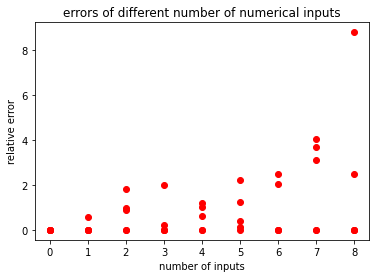

In [ ]:
print(errors)
plt.plot(list(range(nvars)), errors, 'ro') # *** need to fix indexes --> from 1 to nvars
# *** fix this to plot relative error at the end of the DLG process
plt.title('errors of different number of numerical inputs')
plt.xlabel('number of inputs')
plt.ylabel('relative error')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

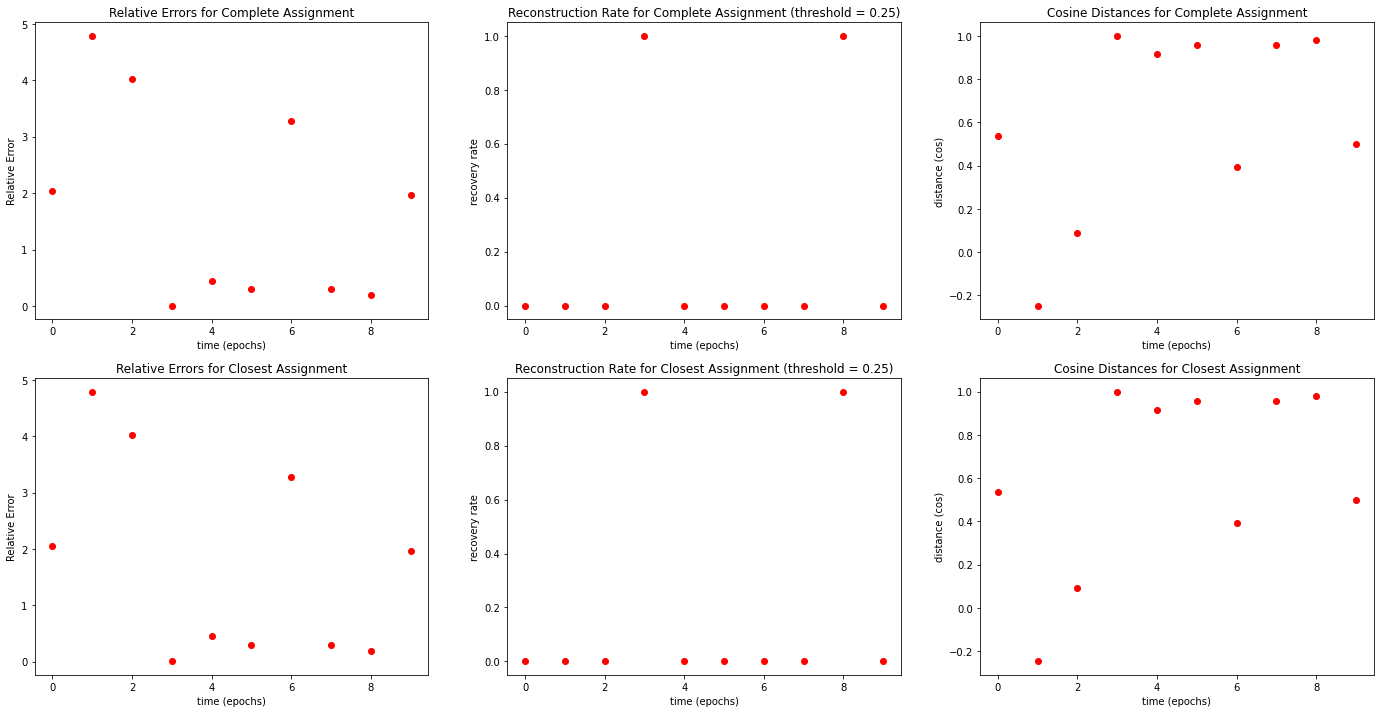

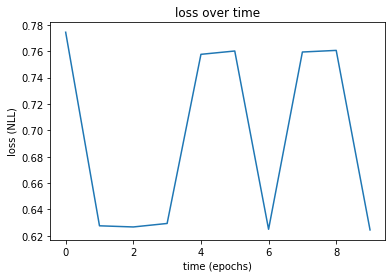

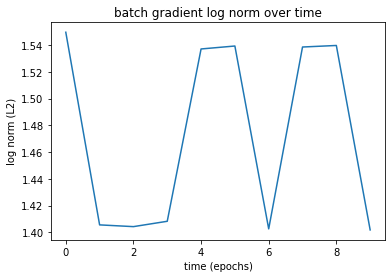

In [ ]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_BRAZPD_1.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_BRAZPD_1_loss.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo
#
# --> randomly sample n features from the baseline set (combine both numerical and categorical variables)
# (not super important) - onehot encoding add an extra bit to indicate missing entry

# future tasks -----------------------------------------------------------
# possibly modify single batch DLG rather than having to run DLG Evolution (debugging purposes --> can already simulate on DLG evolution epochs=1)
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)